# MagicDraw Streaming Demo

[INFO] Initialized with seed  : 1
[INFO] Loading sample images...


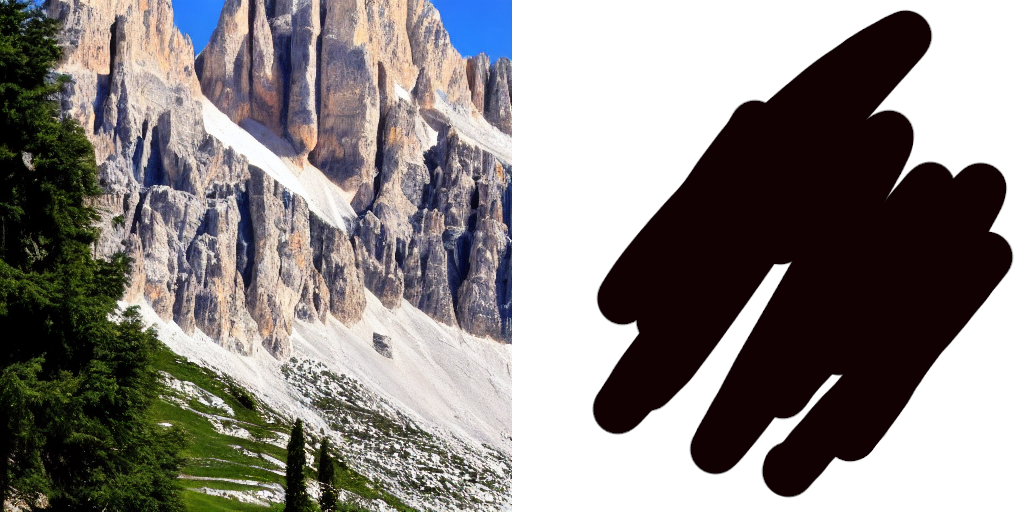

In [1]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from IPython.display import clear_output

from util import seed_everything
from model import StreamMagicDraw


seed = 1
device = 3

device = f'cuda:{device}'
seed_everything(seed)
print(f'[INFO] Initialized with seed  : {seed}')

print('[INFO] Loading sample images...') 
background = Image.open('../assets/dolomites.png')
mask = Image.open('../assets/brush.png')
display(make_image_grid([background, mask], 1, 2))

### Streaming MagicDraw

In [2]:
streamer = StreamMagicDraw(
    device,
    sd_version='1.5',
    height=512,
    width=512,
    cfg_type="none",
)
streamer.prepare()
streamer.register_all(
    background=background,
    masks=mask,
    prompts='a cool-looking flying eagle',
    mask_std=8.0,
    mask_strength=1.0,
)

[INFO] loading stable diffusion...


Loading pipeline components...: 100%|█████████████████████| 7/7 [00:01<00:00,  4.57it/s]


[INFO] Model is loaded!


### Forever run (manually interrupt to stop)

In [ ]:
while True:
    display(sd())
    time.sleep(.5)
    clear_output()